In [1]:
import os
import PIL
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import concurrent.futures

from tqdm import tqdm
from utils import get_file_path, detect_objects_in_image, count_people_in_image, draw_boxes_on_image, set_style, plot_distribution

# Set Matplotlib style
set_style()

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set dataset path
DATASET_PATH = 'dataset/labels.csv'
MODEL_PATH = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'

2023-07-11 18:57:04.791542: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 18:57:04.843440: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-07-11 18:57:04.843468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-07-11 18:57:04.843489: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-11 18:57:04.854902: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 18:57:04.855725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Load dataset
dataset = pd.read_csv(DATASET_PATH)
dataset['file_path'] = dataset['id'].apply(get_file_path)

# Load model
model = hub.load(MODEL_PATH)

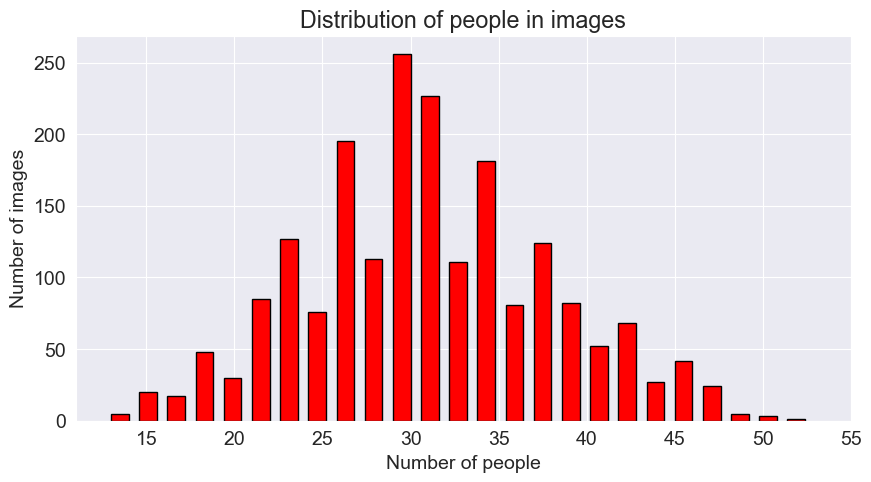

In [9]:
# Plot distribution of people in images
plot_distribution(dataset)

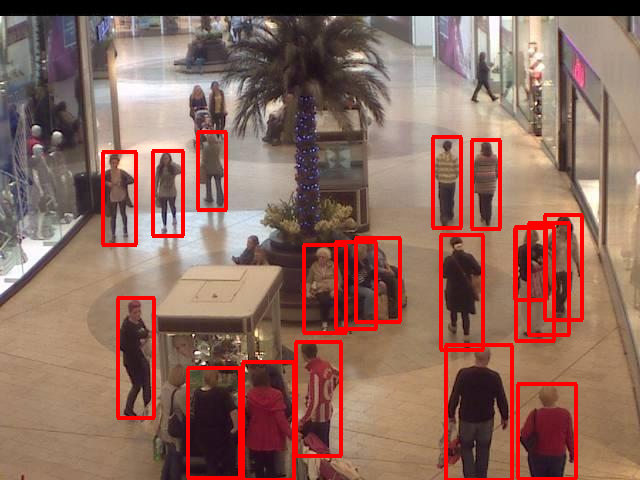

In [3]:
random_image_id = np.random.choice(dataset['id'].unique())
random_image_path = get_file_path(random_image_id)

# Extract number of people in image and draw boxes on image
num_people = detect_objects_in_image(random_image_path, model)
draw_boxes_on_image(random_image_path, num_people, threshold=0.3)

In [4]:
def find_optimal_threshold(
    df: pd.DataFrame,
    start: float = 0.0,
    end: float = 0.5,
    step: float = 0.1
)-> float:
    """
    Finds the optimal threshold for the EfficientDet network.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with image ids and number of people in images.    

    Returns
    -------
    metrics : pd.DataFrame
        Dataframe with metrics for each threshold.
    """
    
    # Set thresholds
    thresholds = np.arange(
        start=start,
        stop=end,
        step=step
    )
    
    metrics = pd.DataFrame(columns=['threshold', 'mae', 'mse'])
    
    # Iterate over thresholds and images
    for threshold in thresholds:
        print(f'Processing threshold: {threshold}')    
        num_people = []
        for image_id in tqdm(df['id'].values):
            image_path = get_file_path(image_id)
            num_people.append(
                count_people_in_image(
                    image_path,
                    model,
                    threshold=threshold
                )
            )
        mae = np.mean(np.abs(df['count'].values - num_people))
        mse = np.mean(np.square(df['count'].values - num_people))
            
        metrics = pd.concat([
            metrics,
            pd.DataFrame({
                'threshold': [threshold],
                'mae': [mae],
                'mse': [mse]
            })
        ])

    # Plot metrics
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(metrics['threshold'], metrics['mae'], label='MAE', marker='o')
    ax_2 = ax.twinx()
    ax_2.plot(metrics['threshold'], metrics['mse'], label='MSE', marker='o')
    
    ax.set_xlabel('Threshold')
    ax_2.set_ylabel('MSE')
    ax.set_ylabel('MAE')
    
    ax.legend()
    ax_2.legend()
    
    plt.show()

    return metrics

In [ ]:
# Find optimal threshold
metrics_1 = find_optimal_threshold(
    dataset.iloc[:200].copy(),
    start=0.0,
    end=0.5,
    step=0.05
)

Processing threshold: 0.1


100%|██████████| 200/200 [01:02<00:00,  3.19it/s]


Processing threshold: 0.10500000000000001


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


Processing threshold: 0.11000000000000001


100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


Processing threshold: 0.11500000000000002


100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


Processing threshold: 0.12000000000000002


100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


Processing threshold: 0.12500000000000003


100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


Processing threshold: 0.13000000000000003


100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


Processing threshold: 0.13500000000000004


100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


Processing threshold: 0.14000000000000004


100%|██████████| 200/200 [01:04<00:00,  3.08it/s]


Processing threshold: 0.14500000000000005


100%|██████████| 200/200 [01:05<00:00,  3.07it/s]


Processing threshold: 0.15000000000000005


100%|██████████| 200/200 [01:07<00:00,  2.95it/s]


Processing threshold: 0.15500000000000005


100%|██████████| 200/200 [01:05<00:00,  3.03it/s]


Processing threshold: 0.16000000000000006


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


Processing threshold: 0.16500000000000006


100%|██████████| 200/200 [01:07<00:00,  2.97it/s]


Processing threshold: 0.17000000000000007


100%|██████████| 200/200 [01:06<00:00,  3.00it/s]


Processing threshold: 0.17500000000000007


100%|██████████| 200/200 [01:07<00:00,  2.98it/s]


Processing threshold: 0.18000000000000008


100%|██████████| 200/200 [01:20<00:00,  2.47it/s]


Processing threshold: 0.18500000000000008


100%|██████████| 200/200 [01:05<00:00,  3.04it/s]


Processing threshold: 0.19000000000000009


100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


Processing threshold: 0.1950000000000001


100%|██████████| 200/200 [01:01<00:00,  3.28it/s]


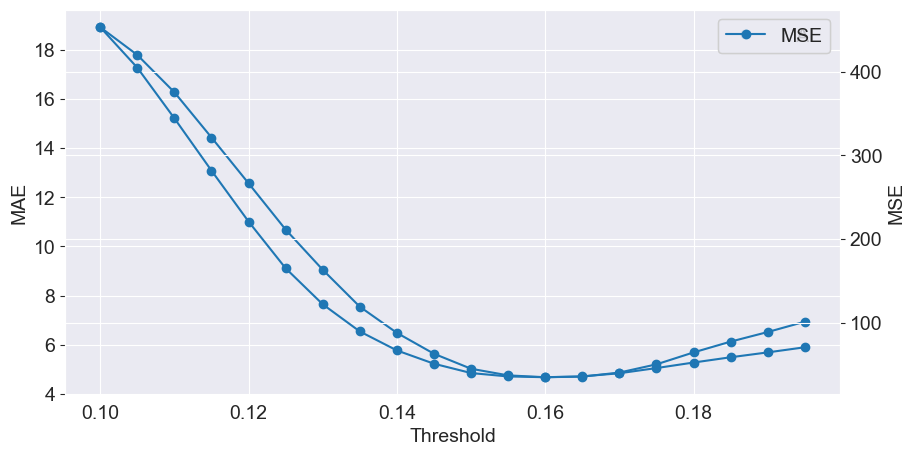

In [47]:
# Find optimal threshold
metrics_2 = find_optimal_threshold(
    dataset.iloc[:200].copy(),
    start=0.1,
    end=0.2,
    step=0.005    
)

Processing threshold: 0.15


100%|██████████| 200/200 [01:10<00:00,  2.85it/s]


Processing threshold: 0.151


100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


Processing threshold: 0.152


100%|██████████| 200/200 [00:55<00:00,  3.57it/s]


Processing threshold: 0.153


100%|██████████| 200/200 [00:53<00:00,  3.76it/s]


Processing threshold: 0.154


100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


Processing threshold: 0.155


100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


Processing threshold: 0.156


100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


Processing threshold: 0.157


100%|██████████| 200/200 [00:49<00:00,  4.02it/s]


Processing threshold: 0.158


100%|██████████| 200/200 [00:54<00:00,  3.70it/s]


Processing threshold: 0.159


100%|██████████| 200/200 [01:10<00:00,  2.84it/s]


Processing threshold: 0.16


100%|██████████| 200/200 [01:20<00:00,  2.48it/s]


Processing threshold: 0.161


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


Processing threshold: 0.162


100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


Processing threshold: 0.163


100%|██████████| 200/200 [01:11<00:00,  2.79it/s]


Processing threshold: 0.164


100%|██████████| 200/200 [01:06<00:00,  2.99it/s]


Processing threshold: 0.165


100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


Processing threshold: 0.166


100%|██████████| 200/200 [00:55<00:00,  3.62it/s]


Processing threshold: 0.167


100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


Processing threshold: 0.168


100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


Processing threshold: 0.169


100%|██████████| 200/200 [00:58<00:00,  3.41it/s]


Processing threshold: 0.17


100%|██████████| 200/200 [00:57<00:00,  3.49it/s]


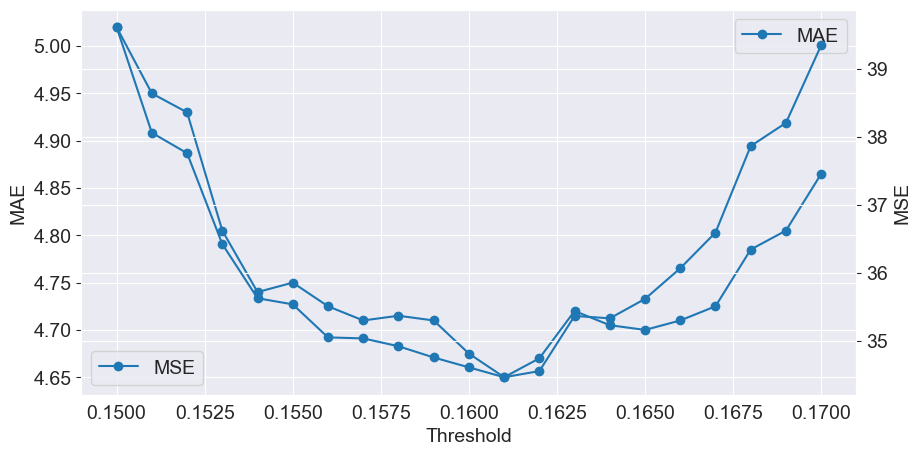

In [51]:
# Find optimal threshold
metrics_3 = find_optimal_threshold(
    dataset.iloc[:200].copy(),
    start=0.15,
    end=0.17,
    step=0.001
)

In [52]:
metrics_3.sort_values(by='mae').head(10)

,threshold,mae,mse
0,0.1610,4.6500,34.4700
0,0.1620,4.6700,34.5600
0,0.1600,4.6750,34.6150
0,0.1650,4.7000,35.6200
0,0.1640,4.7050,35.3350
0,0.1590,4.7100,34.7600
0,0.1570,4.7100,35.0400
0,0.1660,4.7100,36.0700
0,0.1580,4.7150,34.9250
0,0.1630,4.7200,35.3700


In [48]:
"""metrics_1.to_csv(
    os.path.join(
        'results',
        'metrics_1.csv'
    ),
    index=False
)

metrics_2.to_csv(
    os.path.join(
        'results',
        'metrics_2.csv'
    ),
    index=False
)"""

In [53]:
"""metrics_3.to_csv(
    os.path.join(
        'results',
        'metrics_3.csv'
    ),
    index=False
)"""

In [7]:
prediction = pd.DataFrame(columns=['id', 'count'])

prediction[['id', 'count']] = dataset[['id', 'count']].iloc[200:].copy()

prediction['prediction'] = prediction['id'].apply(
    lambda x: count_people_in_image(
        get_file_path(x),
        model=model,
        threshold=0.161
    )
)

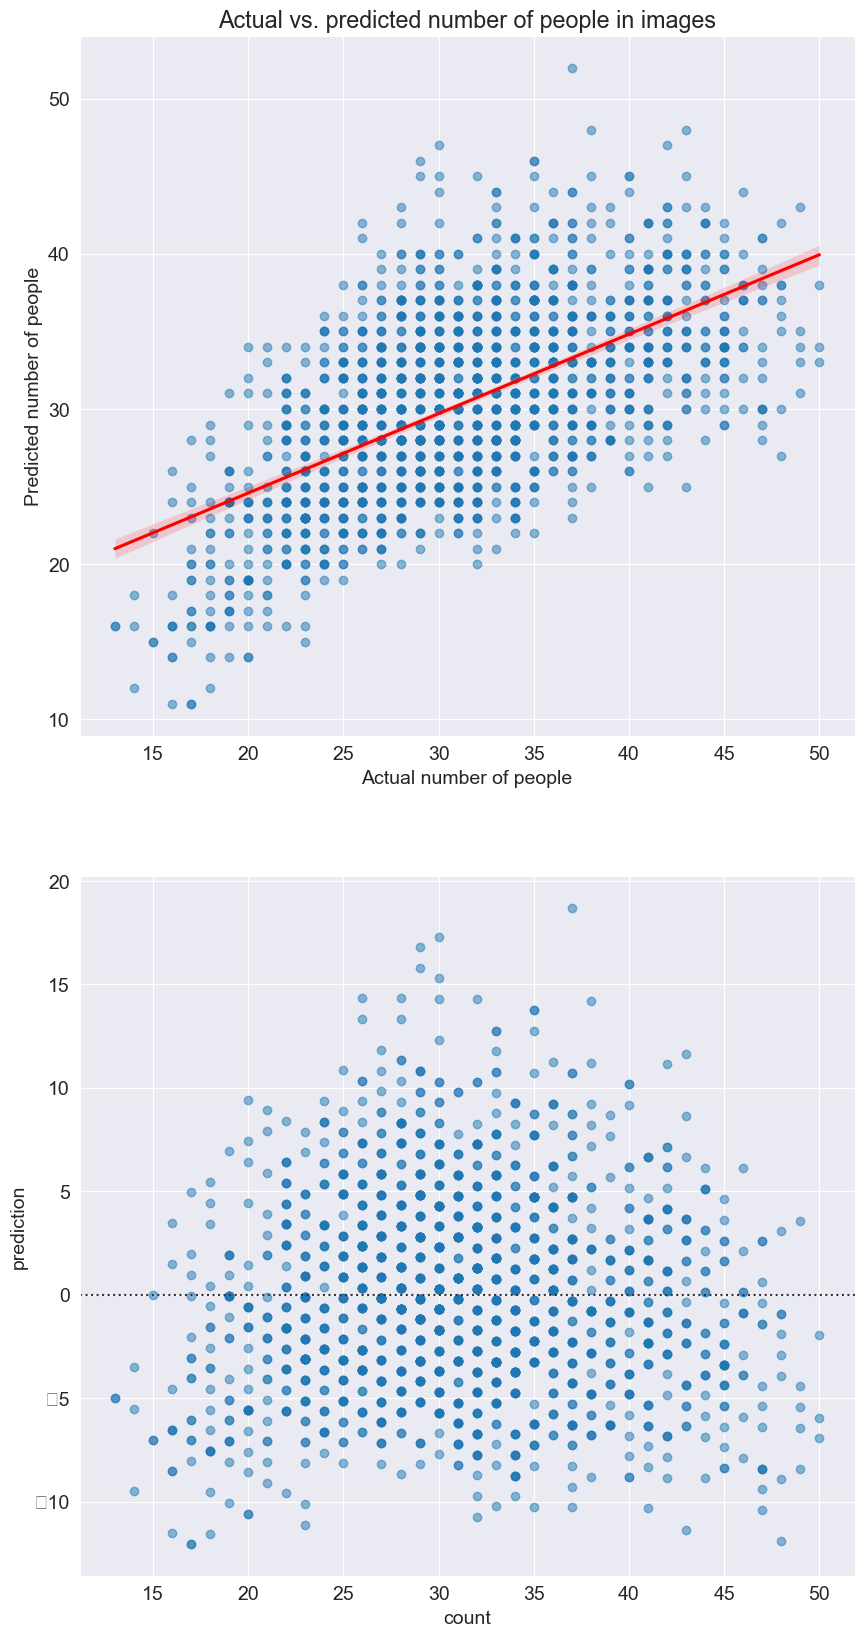

In [22]:
import seaborn as sns

fig, ax = plt.subplots(
    nrows=2,
    figsize=(10, 20)
)

# sns.jointplot(
#     prediction,
#     x='count',
#     y='prediction',
#     kind='reg',
#     scatter_kws={'alpha': 0.5},
#     line_kws={'color': 'red'},
#     ax=ax,
# )

sns.regplot(
    data=prediction,
    x='count',
    y='prediction',
    ax=ax[0],
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
)

sns.residplot(
    data=prediction,
    x='count',
    y='prediction',
    ax=ax[1],
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
)

ax[0].set_xlabel('Actual number of people')
ax[0].set_ylabel('Predicted number of people')

ax[0].set_title('Actual vs. predicted number of people in images')

plt.show()

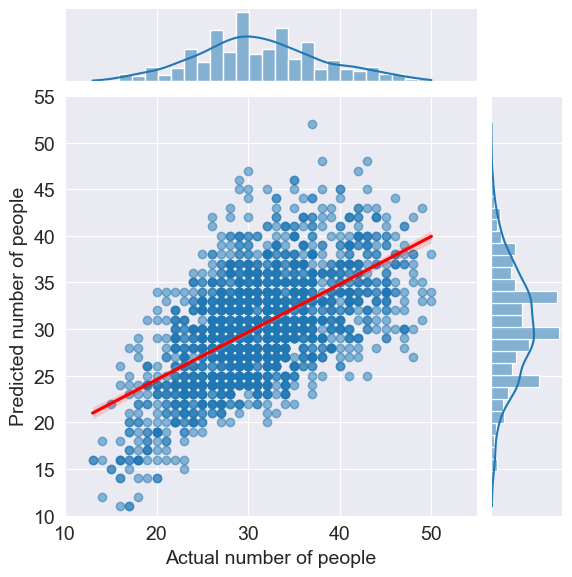

In [28]:
import matplotlib.gridspec as gridspec

sns.jointplot(
    prediction,
    x='count',
    y='prediction',
    kind='reg',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},

)

plt.xlabel('Actual number of people')
plt.ylabel('Predicted number of people')

plt.xlim(10, 55)
plt.ylim(10, 55)

plt.show()

/home/aidin/anaconda3/envs/tf-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


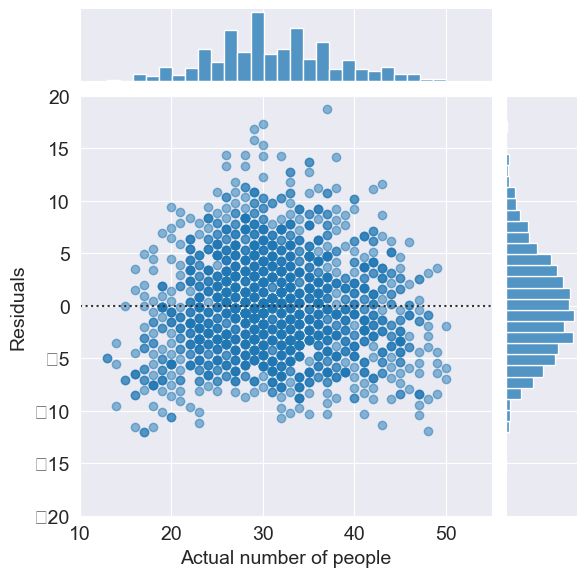

In [29]:
sns.jointplot(
    prediction,
    x='count',
    y='prediction',
    kind='resid',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},

)

plt.xlabel('Actual number of people')
plt.ylabel('Residuals')

plt.xlim(10, 55)
plt.ylim(-20, 20)

plt.show()

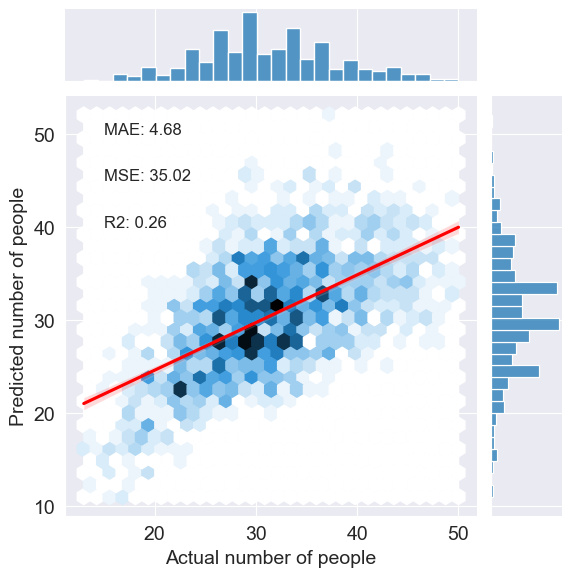

In [40]:
# import mean_absolute_error and mean_squared_error and r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.jointplot(
    prediction,
    x='count',
    y='prediction',
    kind='hex',
)

# Add regression line
sns.regplot(
    data=prediction,
    x='count',
    y='prediction',
    scatter=False,
    line_kws={'color': 'red'},
)

plt.xlabel('Actual number of people')
plt.ylabel('Predicted number of people')

# Print MAE and MSE
plt.text(
    x=15,
    y=50,
    s=f'MAE: {round(mean_absolute_error(prediction["count"], prediction["prediction"]), 2)}',
    fontsize=12
)

plt.text(
    x=15,
    y=45,
    s=f'MSE: {round(mean_squared_error(prediction["count"], prediction["prediction"]), 2)}',
    fontsize=12
)

# Print R2
plt.text(
    x=15,
    y=40,
    s=f'R2: {round(r2_score(prediction["count"], prediction["prediction"]), 2)}',
    fontsize=12
)

plt.show()

In [42]:
prediction.to_csv(
    os.path.join(
        'results',
        'prediction.csv'
    ),
    index=False
)